In [40]:
#install.packages("fredr")
#install.packages("devtools")
#install.packages("ggpubr")

In [64]:
# Load packages for data download and transformation
library(dplyr)
library(fredr)
library(tidyr)

fredr_set_key("xxx")
# Download data
gdp_data <- fredr(
  series_id = "GDPC1",
  observation_start = as.Date("1970-01-01"),
  observation_end = as.Date("2025-01-01")
) %>% rename(gdp = value) %>% mutate(lgdp = log(gdp)) # Take logs
investment_data <- fredr(
  series_id = "GCEC1",
  observation_start = as.Date("1970-01-01"),
  observation_end = as.Date("2025-01-01")
) %>% rename(investment = value) %>% mutate(linvestment = log(investment)) # Take logs
consumption_data <- fredr(
  series_id = "PCEC96",
  observation_start = as.Date("1970-01-01"),
  observation_end = as.Date("2025-01-01")
) %>% rename(consumption = value) %>% mutate(lconsumption = log(consumption)) # Take logs

Warning message:
"Removed 444 rows containing missing values or values outside the scale range (`geom_line()`)."


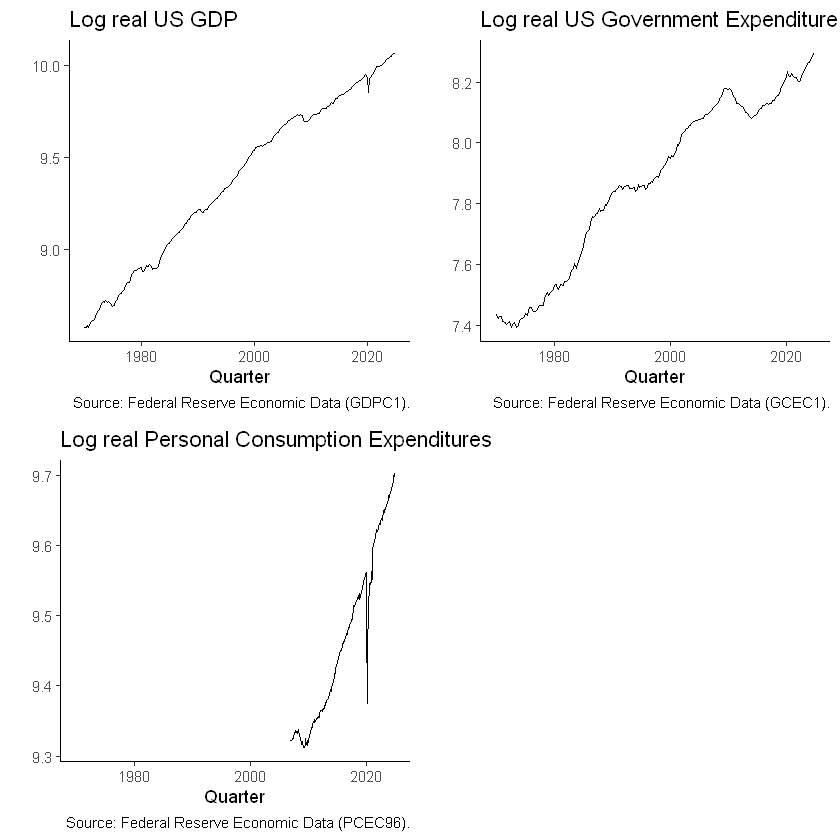

In [66]:
# plot data
library(ggplot2)
library(ggpubr)
gdpplot <- ggplot(gdp_data, aes(x = date, y = lgdp)) +
  geom_line() +
  theme_classic() +
  labs(title = "Log real US GDP", x = "Quarter", y = "",
       caption = "Source: Federal Reserve Economic Data (GDPC1).")
investmentplot <- ggplot(investment_data, aes(x = date, y = linvestment)) +
  geom_line() +
  theme_classic() +
  labs(title = "Log real US Government Expenditure and Investment", x = "Quarter", y = "",
       caption = "Source: Federal Reserve Economic Data (GCEC1).")
consumptionplot <- ggplot(consumption_data, aes(x = date, y = lconsumption)) +
  geom_line() +
  theme_classic() +
  labs(title = "Log real Personal Consumption Expenditures", x = "Quarter", y = "",
       caption = "Source: Federal Reserve Economic Data (PCEC96).")
ggarrange(gdpplot, investmentplot, consumptionplot, ncol = 2, nrow = 2)

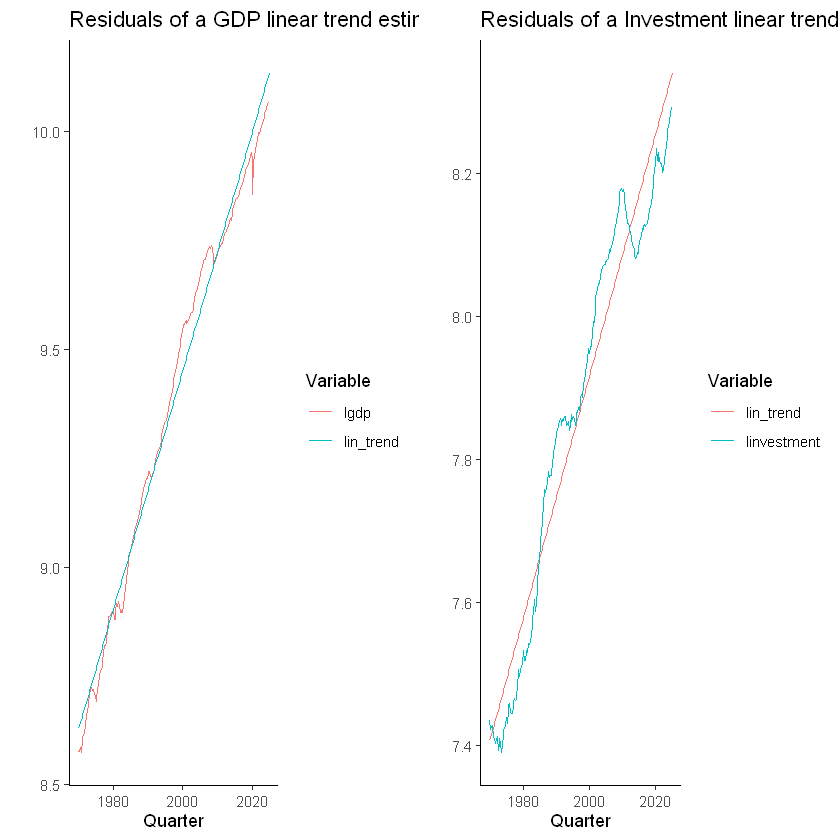

In [67]:
# Add a trend
gdp_data <- gdp_data %>%
  mutate(trend = 1:n())

# Estimate the model with a constant and a trend
time_detrend <- fitted(lm(lgdp ~ trend, data = gdp_data))
names(time_detrend) <- NULL

# Add series to main data frame
gdp_data <- gdp_data %>%
  mutate(lin_trend = time_detrend)

# Create data frame for the plot
gdp_temp <- gdp_data %>%
  select(date, lgdp, lin_trend) %>%
  gather(key = "Variable", value = "value", -date)

# Plot
ltgdpplot = ggplot(gdp_temp, aes(x = date, y = value, colour = Variable)) +
  geom_line() +
  theme_classic() +
  labs(title = "Residuals of a GDP linear trend estimation",
       x = "Quarter", y = "")

# Add a trend
investment_data <- investment_data %>%
  mutate(trend = 1:n())

# Estimate the model with a constant and a trend
time_detrend <- fitted(lm(linvestment ~ trend, data = investment_data))
names(time_detrend) <- NULL

# Add series to main data frame
investment_data <- investment_data %>%
  mutate(lin_trend = time_detrend)

# Create data frame for the plot
investment_temp <- investment_data %>%
  select(date, linvestment, lin_trend) %>%
  gather(key = "Variable", value = "value", -date)

# Plot
ltinvestmentplot = ggplot(investment_temp, aes(x = date, y = value, colour = Variable)) +
  geom_line() +
  theme_classic() +
  labs(title = "Residuals of a Investment linear trend estimation",
       x = "Quarter", y = "")
ggarrange(ltgdpplot, ltinvestmentplot)

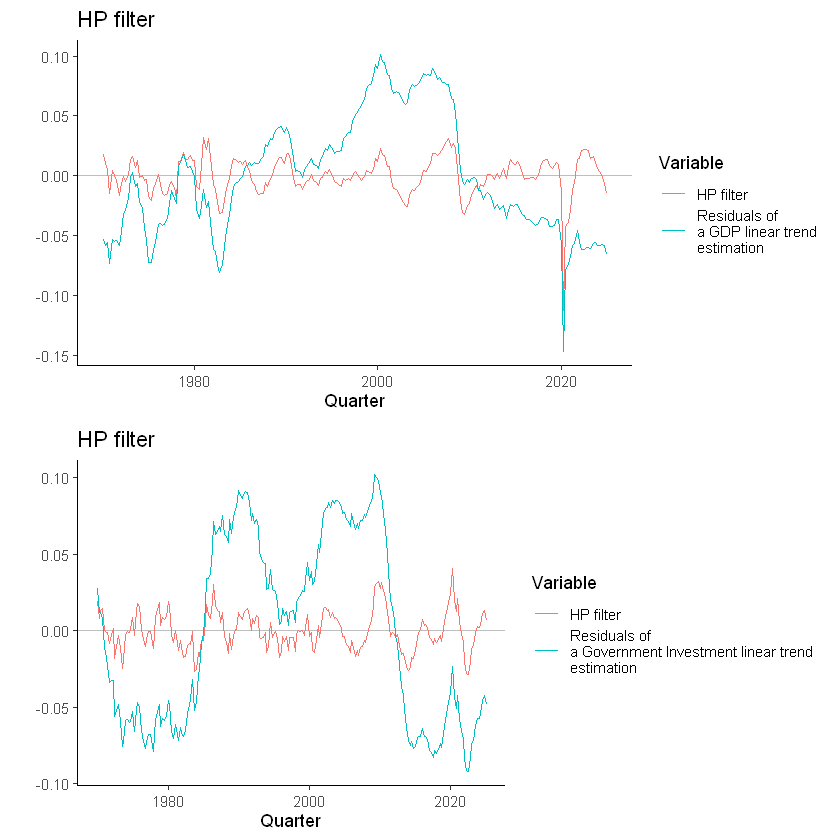

In [70]:
# Load the package
library(mFilter)

# Run HP filter
hp_gdp <- hpfilter(data$lgdp, freq = 1600)

# Add the cyclical component of the HP filter and
# the linearly detrended sereis to the main data frame
gdp_data <- gdp_data %>%
  mutate(hp = hp_gdp$cycle,
         lin_cycle = lgdp - lin_trend)

# Create data frame for the plot
gtemp <- gdp_data %>%
  select(date, hp, lin_cycle) %>%
  gather(key = "Variable", value = "value", -date) %>%
  filter(!is.na(value)) %>%
  mutate(Variable = factor(Variable, levels = c("hp", "lin_cycle"),
                           labels = c("HP filter", "Residuals of\na GDP linear trend\nestimation")))

# Plot
gdphpplot = ggplot(gtemp, aes(x = date, y = value, colour = Variable)) +
  geom_hline(yintercept = 0, colour = "grey") +
  geom_line() +
  theme_classic() +
  labs(title = "HP filter",
       x = "Quarter", y = "")

# Run HP filter
hp_investment <- hpfilter(investment_data$linvestment, freq = 1600)

# Add the cyclical component of the HP filter and
# the linearly detrended sereis to the main data frame
investment_data <- investment_data %>%
  mutate(hp = hp_investment$cycle,
         lin_cycle = linvestment - lin_trend)

# Create data frame for the plot
itemp <- investment_data %>%
  select(date, hp, lin_cycle) %>%
  gather(key = "Variable", value = "value", -date) %>%
  filter(!is.na(value)) %>%
  mutate(Variable = factor(Variable, levels = c("hp", "lin_cycle"),
                           labels = c("HP filter", "Residuals of\na Government Investment linear trend\nestimation")))

# Plot
investmenthpplot = ggplot(itemp, aes(x = date, y = value, colour = Variable)) +
  geom_hline(yintercept = 0, colour = "grey") +
  geom_line() +
  theme_classic() +
  labs(title = "HP filter",
       x = "Quarter", y = "")
ggarrange(gdphpplot, investmenthpplot, ncol = 1, nrow = 2)
